In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sys,json,os
sys.path.append('../../')
import project as prj
import project.tools.statistics as stat
import matplotlib
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['mathtext.fontset'] = 'dejavuserif'

## Plotting differential recoil spectrum

In [2]:
# Initialize the class target. 
material = [[23.,1.],[127.,1.]]
exp = 50.0
thr = 1.0
res = 0.
roi = 40.0
bg = [1.]
target = stat.target(*material, exposure=exp, thr=thr, sigma=res, bg=bg, roi=roi)
# Initialize the vdf for velocity integations.
target.initialize_vdf(I_index = 0) 

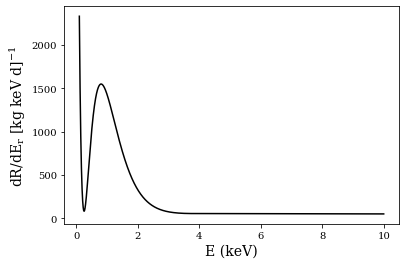

In [3]:
mdm,mzl,gl,gh = 6.,10.,1.6e-10,-1e-12 # mock particle physics parameters
E = np.linspace(.1,10.,10000) # Energy values in keV
df = target.diffrecoil(mdm,mzl,gl,gh,E)
plt.plot(E,target.diffrecoil(mdm,mzl,gl,gh,E), c = 'k')
plt.xlabel('E (keV)', size = 14)
plt.ylabel('$\mathrm{dR/dE_r}$ [kg keV d]$^{-1}$',size = 14);

## Exclusion limit
### Steps:
1. Make samples
2. Calculate exclusion limits
3. Make exclusion limit plots

In [2]:
import project.mk_samples as ms
import project.excllim as ex
import project.plot_ll as pl

In [17]:
# To make samples 
ms.samples(id='1', model=[10,10,0,0,'c'], targets=['Na1','I1'],
           exposure=exp, thr=thr, res=res, bg=bg, roi=10, plot_types=['ph'])

Saved sample data to NaI_1_mock.json in the ouput folder.


<Figure size 432x288 with 0 Axes>

In [6]:
# To calc exclusion limits
ex.excl(9, sample = 'NaI_1_mock.json', plane = 'dmgl', n = 50,
       id = '1', mZ = 10, gl = 0, gh = 1e-13, fin = 5, show_tqdm = True)

100%|██████████| 50/50 [00:03<00:00, 13.11it/s] 


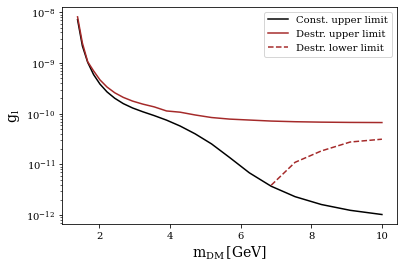

In [18]:
# getting various limit values:
Mdm, glh_c, gll_c, glh_d, gll_d = pl.get_exlims('dmgl_NaI_mock_1.json')
fig,ax = plt.subplots(figsize = (6,4))
ax.plot(Mdm,glh_c, c = 'k', label = 'Const. upper limit')
ax.plot(Mdm,glh_d, c = 'brown', label = 'Destr. upper limit')
ax.plot(Mdm,gll_d, c = 'brown', ls = '--',label = 'Destr. lower limit')
ax.set_yscale('log')
ax.set_xlabel(r'$\mathrm{m_{DM}\,[GeV]}$',size = 14)
ax.set_ylabel(r'$\mathrm{g_{l}}$',size = 14)
ax.legend();

## Reconstruction (in Mdm - Mzl plane)
### Steps
1. Make Samples  
    - Make samples for a given particle physics parameter values.
2. Calculate barys
    - Calculate the contribution of each term (light mediator (L), heavy mediator (H) and 
      interference (I)) to the total number of events for a given mdm,mzl,gl,gh.
    - Since the integration depends only on mdm and mzl (gl and gh are prefactor for L,H and I),
      calculate barys (b0,b1,b2 for L,H and I terms repectively) for all mdm, mzl grid values.
    - This step is done in CLIP where the values b0,b1,b2 for each mdm,mzl pair is stored for
      next step. 
3. Minimize likelihood
    - Using the calculated barys, minimize the likelihood for given mdm and mzl with bl,gl,gh as 
      free parameters. 
    - iminuit is used for this with Quadrant hopping algorithm integrated with iminuit
4. Plot Confidence Intervals (CI)
    - Various CIs can be plotted (contour plots) with the profiles likelihoods and its global minimum. 

In [3]:
import project.mk_barys as pb
import project.minimize_ll as pm

In [6]:
ms.samples(id = '2', model = [mdm,mzl,gl,gh,'d'],roi = 10,seed = 3544,plot_types = ['ph'])

Saved sample data to NaI_2_mock.json in the ouput folder.


<Figure size 432x288 with 0 Axes>

In [7]:
# It is recommended to not run this unsupervised in Notebook, since multiprocessing is used.
# Best to run in CLIP.
pb.mk_barys('NaI_2_mock.json',N = 40,Nbins = 30,fin = 5)

Total work completed in 0.9441613157590231 mins


In [9]:
# Recommended to run in CLIP.
# Reconstruction with background normalziation as the only nuisance parameter
# Minimizing likelihood using quadrant hopping algorithm and iminuit migrad() function
# Ignore the warning "E VariableMetricBuilder Initial matrix not pos.def."
pm.min_ll('NaI_2_mock.json','NaI_2_mock_barys_.json',Nbins = 30, fin = 5, N = 40, 
          interference = 'd', reconst_key = 'bl', id = 'bl')

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
Total work completed in 0.24217513004938762 mins


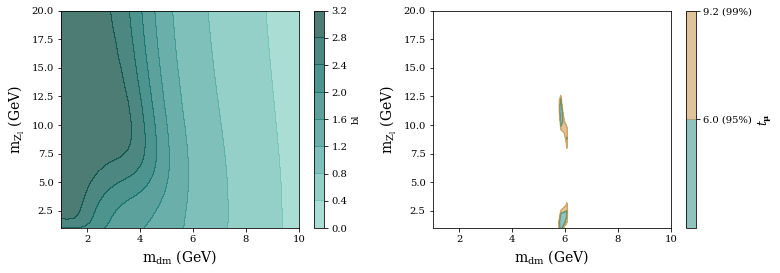

In [13]:
res_bl = json.load(open('../Output/NaI_2_mock_reconst_bl.json','r'))
ana_bl = pl.Analyze([res_bl],nuis_params = ['bl'])
fig,axs = plt.subplots(1,2,figsize = (12,4), gridspec_kw = {'wspace':0.25})
ana_bl.plot_param('bl',ax = axs[0])
ana_bl.plot_CI(alpha = 0.5, ax = axs[1])

In [3]:
# Reconstruction with bl and gl as nuisance parameters
pm.min_ll('NaI_2_mock.json','NaI_2_mock_barys_.json',Nbins = 30, fin = 5, N = 40, 
          interference = 'd', reconst_key = 'blgl', id = 'blgl')

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

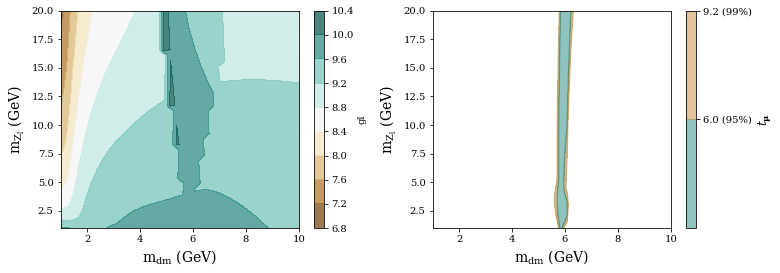

In [19]:
res_blgl = json.load(open('../Output/NaI_2_mock_reconst_blgl.json','r'))
ana_blgl = pl.Analyze([res_blgl],nuis_params = ['bl','gl'])
fig,axs = plt.subplots(1,2,figsize = (12,4), gridspec_kw = {'wspace':0.25})
ana_blgl.plot_param(['gl',lambda x: -np.log10(x)], ax = axs[0], cmap = pl.Brbg)
ana_blgl.plot_CI(ax = axs[1], alpha = 0.5)

In [4]:
pm.min_ll('NaI_2_mock.json','NaI_2_mock_barys_.json',Nbins = 30, fin = 5, N = 40,
          interference = 'd', reconst_key = 'blglgh', id = 'blglgh')

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
Total work completed in 4.424457410971324 mins


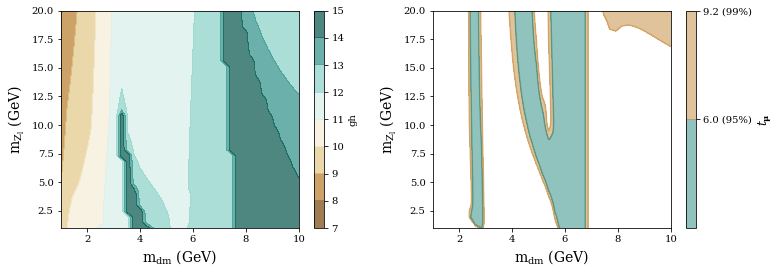

In [7]:
res_blglgh = json.load(open('../Output/NaI_2_mock_reconst_blglgh.json','r'))
ana_blglgh = pl.Analyze([res_blglgh],nuis_params = ['bl','gl','gh'])
fig,axs = plt.subplots(1,2,figsize = (12,4), gridspec_kw = {'wspace':0.25})
ana_blglgh.plot_param(['gh',lambda x: -np.log10(-x)], ax = axs[0], cmap = pl.Brbg)
ana_blglgh.plot_CI(ax = axs[1], alpha = 0.5)

In [4]:
pm.min_ll('NaI_2_mock.json','NaI_2_mock_barys_.json',Nbins = 30, fin = 5, N = 40,
          interference = 'd', reconst_key = 'blrh', id = 'blrh')

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
Total work completed in 0.4598641355832418 mins


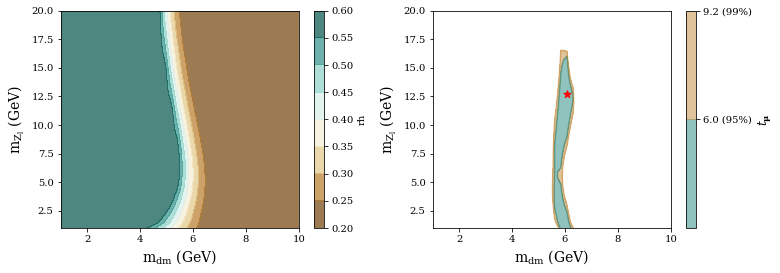

In [4]:
res_blrh = json.load(open('../Output/NaI_2_mock_reconst_blrh.json','r'))
ana_blrh = pl.Analyze([res_blrh],nuis_params = ['bl','rh'])
fig,axs = plt.subplots(1,2,figsize = (12,4), gridspec_kw = {'wspace':0.25})
ana_blrh.plot_param('rh', ax = axs[0], cmap = pl.Brbg)
ana_blrh.plot_CI(ax = axs[1], alpha = 0.5)

In [6]:
pm.min_ll('NaI_2_mock.json','NaI_2_mock_barys_.json',Nbins = 30, fin = 5, N = 40,
          interference = 'd', reconst_key = 'blglrh', id = 'blglrh')

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMe

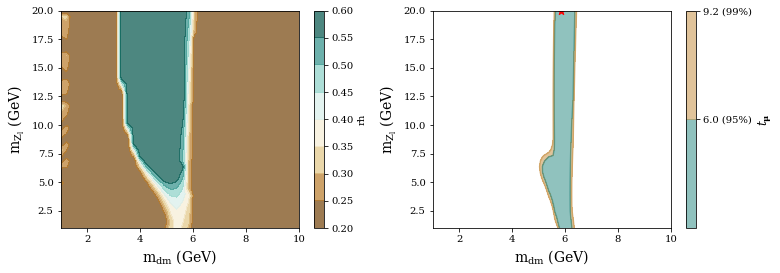

In [7]:
res_blglrh = json.load(open('../Output/NaI_2_mock_reconst_blglrh.json','r'))
ana_blglrh = pl.Analyze([res_blglrh],nuis_params = ['bl','gl','rh'])
fig,axs = plt.subplots(1,2,figsize = (12,4), gridspec_kw = {'wspace':0.25})
ana_blglrh.plot_param('rh', ax = axs[0], cmap = pl.Brbg)
ana_blglrh.plot_CI(ax = axs[1], alpha = 0.5)

In [4]:
pm.min_ll('NaI_2_mock.json','NaI_2_mock_barys_.json',Nbins = 30, fin = 5, N = 40,
          interference = 'd', reconst_key = 'blglghrh', id = 'blglghrh')

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
Total work completed in 15.971575085322062 mins


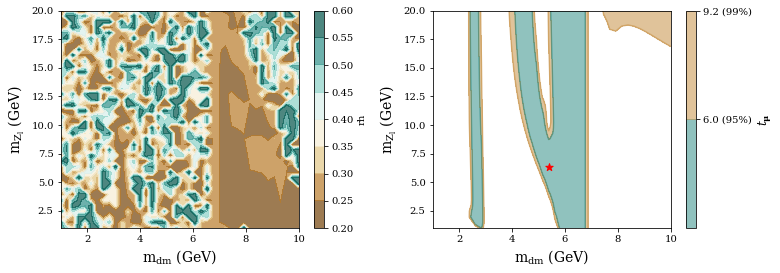

In [6]:
res_blglghrh = json.load(open('../Output/NaI_2_mock_reconst_blglghrh.json','r'))
ana_blglghrh = pl.Analyze([res_blglghrh],nuis_params = ['bl','gl','gh','rh'])
fig,axs = plt.subplots(1,2,figsize = (12,4), gridspec_kw = {'wspace':0.25})
ana_blglghrh.plot_param('rh', ax = axs[0], cmap = pl.Brbg)
ana_blglghrh.plot_CI(ax = axs[1], alpha = 0.5)